In [3]:
from scipy.optimize import leastsq,curve_fit
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
import math as math

Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [16]:
def dist(p1,p2):
    cant1 = np.abs(p1[0] - p2[0])
    cant2 = np.abs(p1[1] - p2[1])
    dist = np.sqrt((cant1**2) + (cant2**2))
    return dist

def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return distances

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)

def func(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x+b)
    return residual

def lineal(x,a,b):
    return a*x+b

def exp(params, x, y):
    a, b = params[0], params[1]
    residual = y-(a*x**b)
    return residual

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point
    
    
params = [1, 1]

def evento(poligono,pointsx,pointsy,sigma,evento,recta,angulo):
    #Genero el punto random.
    random_point = in_hex(poligono)
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
    #Genero la señal 
    y = 100 - (100/433)*np.asarray(distancias)
    #Hago el ajuste
    y_random = np.random.normal(y,sigma,size = len(y))
    a1 = leastsq(func, params, (np.asarray(distancias), y_random))[0][1]
    a2 = leastsq(func, params, (np.asarray(distancias), y_random))[0][0]
    #Opcional visualizar el esquematico del evento
    if evento == True:
        plt.figure(figsize=(8,8))
        polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
        plt.gca().add_patch(polygon)
        plt.xlim(-600,600)
        plt.ylim(-600,600)
        plt.scatter(centro[0],centro[1],s = 100,c ='black')
        plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
        plt.scatter(pointsx,pointsy,s = 100,c = 'black')
        plt.grid(linestyle='--')
        plt.show()
    #Opcional visualizar el ajuste del evento
    x =  np.linspace(100,800)
    y = a1 + a2*x
    if recta == True:
        plt.figure(figsize=(7,7))
        plt.plot(x,y)
        plt.plot(distancias,y_random,'o',color = 'orange')
        plt.errorbar(distancias,y_random,yerr =sigma,ls = 'none',ecolor='black')
        plt.title('Ajuste del evento',size = 20)
        plt.grid(linestyle='--')
        plt.plot([],[],' ',label = f'Ordenada = {np.round(a1,3)}')
        plt.plot([],[],' ',label = f'Pendiente = {np.round(a2,3)}')
        plt.ylabel('y(x)',size = 16)
        plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.xlabel('x',size = 16)
    #Calculo la matriz de covarianza
    Sum_x = np.sum(distancias)
    Sum_x2 = np.sum(distancias**2)
    N = len(distancias)
    Delta = (N * Sum_x2) - (Sum_x ** 2)
    cov = np.matrix([[(sigma**2/Delta)*Sum_x2,-(sigma**2/Delta)*Sum_x],[-(sigma**2/Delta)*Sum_x,(sigma**2/Delta)*N]])
    return(distancias,y_random,np.round(a1,5),np.round(a2,5),np.mean(distancias),cov)

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

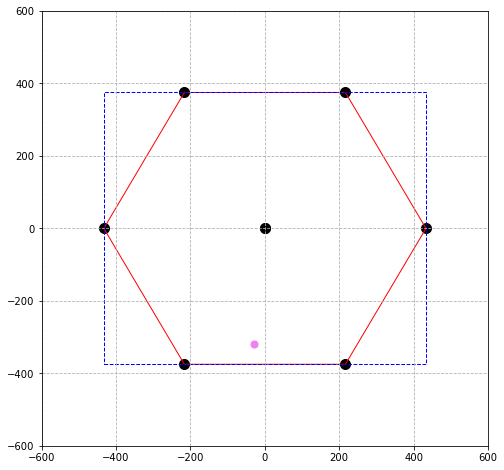

In [5]:
poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
random_point = in_hex(poligono)
centro = (0,0)


distancias = []
for i in range(len(poligono)):
    distancias.append(dist(random_point,poligono[i]))
    
distancias.append(dist(centro,random_point))
    

plt.figure(figsize=(8,8))
polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
rectangle = plt.Rectangle(rectangulo[0],width = 865, height = 750,fill=None,linestyle = '--',edgecolor='b')
plt.gca().add_patch(polygon)
plt.gca().add_patch(rectangle)
plt.xlim(-600,600)
plt.ylim(-600,600)
plt.scatter(centro[0],centro[1],s = 100,c ='black')
plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
plt.scatter(pointsx,pointsy,s = 100,c = 'black')
plt.grid(linestyle='--')
plt.show()

Chequeo las distancias entre los verrtices para que sean todas aproximadamente 433. Chequeo que el centro este bien colocado tal que su distancia al resto de los vertices sea tambien 433.

In [6]:
for i in range(len(poligono)):
    if i == len(poligono)-1:
        print(f'disttancia entre vertices: {dist(poligono[0],poligono[len(poligono)-1])}')
    if i < len(poligono)-1:
        print(f'distancia entre vertices: {dist(poligono[i],poligono[i+1])}')
        
for i in range(len(poligono)):
    print(f'distancias entre vertices y el centro: {dist(centro,poligono[i])}')

distancia entre vertices: 433.0
distancia entre vertices: 433.00952645409546
distancia entre vertices: 433.00952645409546
distancia entre vertices: 433.0
distancia entre vertices: 433.00952645409546
disttancia entre vertices: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.0
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.00952645409546
distancias entre vertices y el centro: 433.0


Genero los puntos y a partir de la relacion lineal.

In [7]:
y = 100 - (100/433)*np.asarray(distancias)
sigma = 5
y

array([ 54.89734153,  41.74009234, -29.72898578, -70.01739815,
       -65.96972204, -18.78415581,  26.04296713])

Genero 1000 puntos de y al azar y obtengo los parametros de la recta que mejor los ajustan.

In [8]:
a1 = []
a2 = []

for i in range(1000):
    valores_y = (np.random.normal(loc = y, scale = sigma))
    a1.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][1])
    a2.append(leastsq(func, params, (np.asarray(distancias), valores_y))[0][0])
    
print(f'Parametros obtenidos por Monte carlo = {np.mean(a1),np.mean(a2)}')
print(f'Parametros originales = {(100,-100/433)}')                                                                                      


Parametros obtenidos por Monte carlo = (99.92441780958075, -0.23103018724026633)
Parametros originales = (100, -0.23094688221709006)


Grafico los histogramas de la pendiente y la ordenada

Text(0.5, 0, '$a_{2}$')

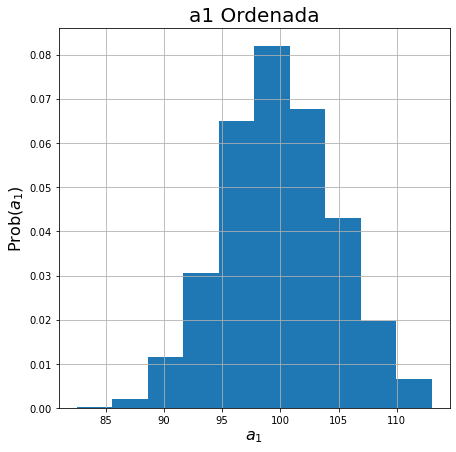

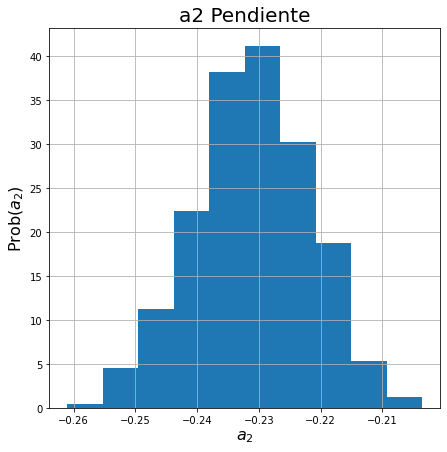

In [9]:
plt.figure(figsize=(7,7))
plt.hist(a1,density=True)
plt.title('a1 Ordenada',size = 20)
plt.grid()
plt.ylabel('Prob($a_{1}$)',size = 16)
plt.xlabel('$a_{1}$',size = 16)



plt.figure(figsize=(7,7))
plt.hist(a2,density=True)
plt.title('a2 Pendiente',size = 20)
plt.grid()
plt.ylabel('Prob($a_{2}$)',size = 16)
plt.xlabel('$a_{2}$',size = 16)

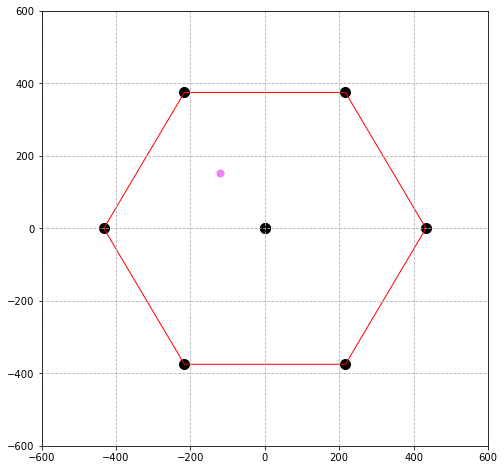

(array([426.53115939, 596.74174711, 566.1369601 , 330.04580842,
        223.6820189 , 296.13775654, 188.14364541]),
 array([  4.71832118, -38.70158248, -33.01298957,  15.6614613 ,
         47.9690652 ,  21.5982886 ,  55.47739877]),
 94.89544,
 -0.22477,
 375.3455851241039,
 matrix([[ 2.63815406e+01, -6.07709613e-02],
         [-6.07709613e-02,  1.61906690e-04]]))

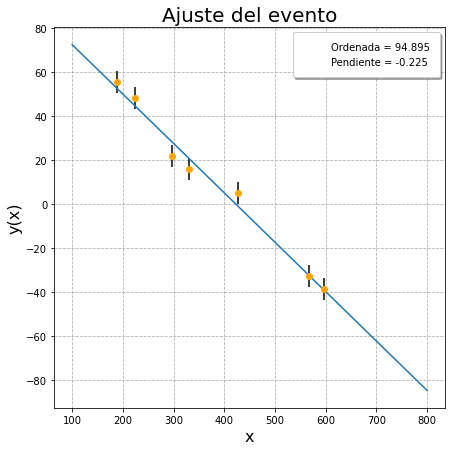

In [10]:
evento(poligono,pointsx,pointsy,5,True,True,40)

In [11]:
dist_optima = np.zeros(3000)
for i in range(len(dist_optima)):
    dist_optima[i] = evento(poligono,pointsx,pointsy,5,False,False,40)[4]

Text(0.5, 0, 'Distancia')

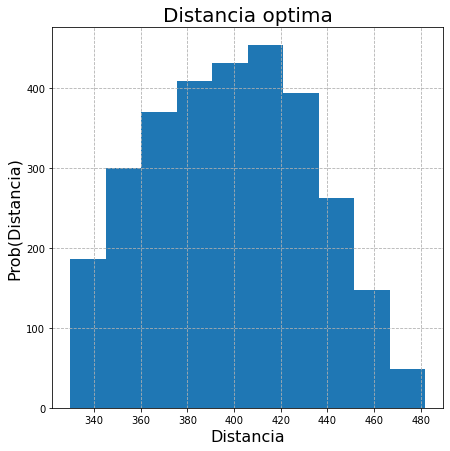

In [12]:
plt.figure(figsize=(7,7))
plt.hist(dist_optima)
plt.title('Distancia optima',size = 20)
plt.grid(linestyle = '--')
plt.ylabel('Prob(Distancia)',size = 16)
plt.xlabel('Distancia',size = 16)


In [13]:
angles = np.linspace(0,40,11)
mean = np.zeros(len(angles))
median = np.zeros(len(angles))

for i in range(len(angles)):
    dist_optima = np.zeros(2000)
    for j in range(len(dist_optima)):
        dist_optima[j] = evento(poligono,pointsx,pointsy,5,False,False,angles[i])[4]
    mean[i] = np.mean(dist_optima)
    median[i] = np.median(dist_optima)

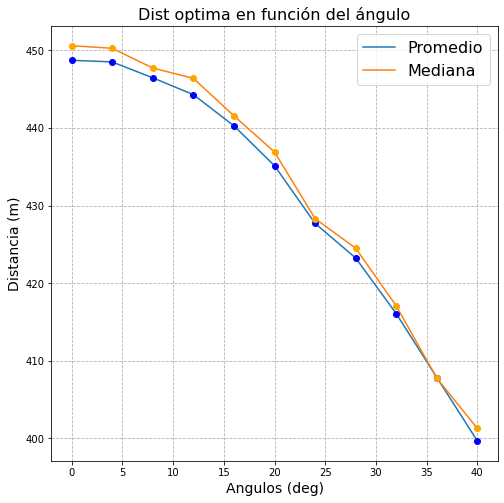

In [14]:
plt.figure(figsize=(8,8))
plt.title('Dist optima en función del ángulo',size = 16)
plt.plot(angles,mean,label = 'Promedio')
plt.plot(angles,median, label = 'Mediana')
plt.plot(angles,mean,'o',color='blue')
plt.plot(angles,median,'o',color='orange')
plt.xlabel('Angulos (deg)',size=14)
plt.ylabel('Distancia (m)',size=14)
plt.grid(linestyle = '--')
plt.legend(fontsize=16)

101.00635149023489 -0.23462331860415386


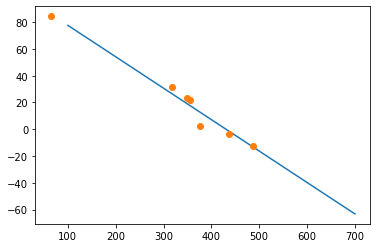

In [45]:
random_point = in_hex(poligono)
angulo = 40
#calculo las distancias entre el evento y los 7 detectores.
distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])
#Genero la señal 
parametros = [100,100/433]
y = parametros[0] - parametros[1]*np.asarray(distancias)
#Hago el ajuste
sigma = 5
y_random = np.random.normal(loc = y, scale = sigma, size = len(distancias))
#a1 = leastsq(func, params, (np.asarray(distancias), y_random))[0][1]
#a2 = leastsq(func, params, (np.asarray(distancias), y_random))[0][0]
test = curve_fit(lineal,distancias,y_random,p0=[parametros[1],parametros[0]])
x_t = np.linspace(100,700)
y_t = test[0][1] + test[0][0]*x_t
plt.plot(x_t,y_t)
plt.plot(distancias,y_random,'o')
print(test[0][1],test[0][0])

In [ ]:
parametros = [1,2]
x = np.linspace(2,3,11)
y = parametros[0]*x**parametros[1]

x_log = np.log(x)
y_log = np.log(parametros[0]) + parametros[1] * x_log

sigma = 0.3
sigma1 = sigma/x

m = []
for i in range(len(x)):
    m.append([1,x[i]])
m1 = []
for i in range(len(x)):
    m1.append([1,x_log[i]])

A = np.asmatrix(m)
A1 = np.asmatrix(m1)

V = np.zeros((len(x),len(x)))
np.fill_diagonal(V, sigma) 

V1 = np.zeros((len(x),len(x)))
np.fill_diagonal(V1, sigma1) 


cov = np.linalg.inv(np.dot(np.dot(np.matrix.transpose(A),np.linalg.inv(V)),A))
cov1 = np.linalg.inv(np.dot(np.dot(np.matrix.transpose(A1),np.linalg.inv(V1)),A1))

cov,cov1

$r_{0}$ = 300 ;
$\beta$ = 2.1 ; 
$S_{0}$ = 35 ; Dejamos variar los datos simulados como la raiz de 35.